# Portfolio 4

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, r2_score, mean_squared_error

In [2]:
student_name = "Petr Gizatullin"
student_id = "48101052"

## Data

For this task I chose to explore and analyse the Australian 2021 Census data and Australian 2022 Federal Election data.

### Census
The Census dataset (cd) was acquired from Australian Bureau of Statistics. It contains information about the number of people of each age (starting from 18), education level and income bracket in each of Australian Commonwealth Electoral Division as of 2021 Federal Census.
|Column|Meaning|
|:-----:|:-----:|
|Counting|Method of counting|
|CED (UR)|Commonwealth Electoral Division|
|AGEP Age|Age|
|1-digit level HEAP Level of Highest Educational Attainment|Level of Highhest Education|
|INCP Total Personal Income (weekly)|Weekly Personal Income bracket|
|Count|Number of people in this category|


### Election
The Election dataset (ed) was acquired from Australian Electoral Commission. It contains information on the results of 2022 Federal Election by Commonwealth Electoral Division (CED), i.e. data about a winning candidate in each Electoral Division in Australia.
|Column|Meaning|
|:-----:|:-----:|
|DivisionID|CED ID|
|DivisionNm|CED Name|
|StateAb|CED State or Territory|
|CandidateID|Winning Candidate's ID|
|GivenNm|Winning Candidate's First Name|
|Surname|Winning Candidate's Last Name|
|PartyNm|Winning Candidate's Party Name|
|PartyAb|Winning Candidate's Party Name Abbreviation|

In [3]:
#Open and read Census Data (cd)
cd = pd.read_csv('Data/census.csv')
cd.head()

,Counting,CED (UR),AGEP Age,1-digit level HEAP Level of Highest Educational Attainment,INCP Total Personal Income (weekly),Count
0,Person Records,Banks,18,Postgraduate Degree Level,Negative income,0
1,Person Records,Banks,18,Postgraduate Degree Level,Nil income,0
2,Person Records,Banks,18,Postgraduate Degree Level,"$1-$149 ($1-$7,799)",0
3,Person Records,Banks,18,Postgraduate Degree Level,"$150-$299 ($7,800-$15,599)",0
4,Person Records,Banks,18,Postgraduate Degree Level,"$300-$399 ($15,600-$20,799)",0


In [4]:
#Open and read Election Data (ed)
ed = pd.read_csv('Data/election.csv')
ed.head()

,DivisionID,DivisionNm,StateAb,CandidateID,GivenNm,Surname,PartyNm,PartyAb
0,179,Adelaide,SA,36973,Steve,GEORGANAS,Australian Labor Party,ALP
1,197,Aston,VIC,36704,Alan,TUDGE,Liberal,LP
2,198,Ballarat,VIC,36409,Catherine,KING,Australian Labor Party,ALP
3,103,Banks,NSW,37018,David,COLEMAN,Liberal,LP
4,180,Barker,SA,37083,Tony,PASIN,Liberal,LP


## Problem

Based on the acquired data the proposed problem is to estimate if demographic data, i.e. age, education and income influence the election results in any given Australian Electoral Division and try to predict the outcome of an election in a Division based on demographic data.

## Data Preparation

First, we have to clean and evaluate the datasets, starting with and Election Dataset.

### Election Dataset Evaluation & Preparation

In [5]:
#Output Election Data
ed

,DivisionID,DivisionNm,StateAb,CandidateID,GivenNm,Surname,PartyNm,PartyAb
0,179,Adelaide,SA,36973,Steve,GEORGANAS,Australian Labor Party,ALP
1,197,Aston,VIC,36704,Alan,TUDGE,Liberal,LP
2,198,Ballarat,VIC,36409,Catherine,KING,Australian Labor Party,ALP
3,103,Banks,NSW,37018,David,COLEMAN,Liberal,LP
4,180,Barker,SA,37083,Tony,PASIN,Liberal,LP
...,...,...,...,...,...,...,...,...
146,153,Werriwa,NSW,36810,Anne Maree,STANLEY,Australian Labor Party,ALP
147,150,Whitlam,NSW,36811,Stephen,JONES,Australian Labor Party,ALP
148,178,Wide Bay,QLD,37506,Llew,O'BRIEN,Liberal National Party of Queensland,LNP
149,234,Wills,VIC,36452,Peter,KHALIL,Australian Labor Party,ALP


The dataset has reasonable formatting. From this dataset we only need two fields - Division Name and Winning Party Name. First we should check if these fields have reasonable values.

In [6]:
#Output unique Division and Party names
print(ed.DivisionNm.value_counts(), '/n')
print(ed.PartyNm.value_counts())

DivisionNm
Adelaide     1
Lyons        1
Mackellar    1
Macnamara    1
Macquarie    1
            ..
Flinders     1
Flynn        1
Forde        1
Forrest      1
Wright       1
Name: count, Length: 151, dtype: int64 /n
PartyNm
Australian Labor Party                  77
Liberal                                 27
Liberal National Party of Queensland    21
The Nationals                           10
Independent                             10
The Greens                               4
Katter's Australian Party (KAP)          1
Centre Alliance                          1
Name: count, dtype: int64


Division names have reasonable values - each has only one count, and there 151 Division names, which corresponds with a total number of CEDs.

Party names also have reasonable values. However, during the 2022 Federal Election Liberal Party, Liberal National Party of QLD and The Nationals formed the Liberal-National Coalition. For the sake of this analysis it is also reasonable to unite them as a Coalition.

In [7]:
#List of Parties that form a Liberal-National Coalition
coal_list = ["Liberal", "Liberal National Party of Queensland", "The Nationals"]

#Leave only relevant fields
ed = ed[["DivisionNm", "PartyNm"]]

In [8]:
#Acknowledge if winning party is in a L-N Coalition and replace
ed.loc[ed["PartyNm"].isin(coal_list), "PartyNm"] = "Liberal-National Coalition"

#Rename DivisionNm column to CED and set as index
ed = ed.rename(columns={'DivisionNm':'CED'})
ed = ed.set_index(ed.columns[0])
ed

C:\Users\ECH\AppData\Local\Temp\ipykernel_22576\3539364458.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ed.loc[ed["PartyNm"].isin(coal_list), "PartyNm"] = "Liberal-National Coalition"


,PartyNm
CED,
Adelaide,Australian Labor Party
Aston,Liberal-National Coalition
Ballarat,Australian Labor Party
Banks,Liberal-National Coalition
Barker,Liberal-National Coalition
...,...
Werriwa,Australian Labor Party
Whitlam,Australian Labor Party
Wide Bay,Liberal-National Coalition


### Census Dataset Evaluation

Next we should prepare the 2021 Census Dataset. 

In [9]:
#Output Census Dataset
cd

,Counting,CED (UR),AGEP Age,1-digit level HEAP Level of Highest Educational Attainment,INCP Total Personal Income (weekly),Count
0,Person Records,Banks,18,Postgraduate Degree Level,Negative income,0
1,Person Records,Banks,18,Postgraduate Degree Level,Nil income,0
2,Person Records,Banks,18,Postgraduate Degree Level,"$1-$149 ($1-$7,799)",0
3,Person Records,Banks,18,Postgraduate Degree Level,"$150-$299 ($7,800-$15,599)",0
4,Person Records,Banks,18,Postgraduate Degree Level,"$300-$399 ($15,600-$20,799)",0
...,...,...,...,...,...,...
2949403,Person Records,Total,115,Not applicable,"$2,000-$2,999 ($104,000-$155,999)",0
2949404,Person Records,Total,115,Not applicable,"$3,000-$3,499 ($156,000-$181,999)",0
2949405,Person Records,Total,115,Not applicable,"$3,500 or more ($182,000 or more)",0
2949406,Person Records,Total,115,Not applicable,Not stated,0


This Dataset is very large, and unconventioanlly structured. Instead of each row being one observation, for example a person with a set of characteristics, each row represents some combination of characteristics - Electoral District, Age, Highest Education Level and Personal Income, and then the amount of people recorded to have this combination of characteristics in the Count field.

We should:
1) Rename the columns so there are no spaces in the names
2) Rename the Count column, since it can be mixed up with the Count function
3) Remove Counting field and Total CED name, as they are irrelevant for this analysis
4) Transform Age and Group_Count columns to int instead of float

In [10]:
#Rename columns
cd = cd.rename(columns={'CED (UR)':'CED', 'AGEP Age':'Age', '1-digit level HEAP Level of Highest Educational Attainment':'Education', 'INCP Total Personal Income (weekly)':'Income', "Count":"Group_Count"})

#Remove Counting column and Total row
cd = cd.drop("Counting", axis = 1)
cd = cd[cd.CED != "Total"]

#Set numeric columns to int
cd.loc[:, "Age"] = cd["Age"].astype(int)
cd.loc[:, "Group_Count"] = cd["Group_Count"].astype(int)

Next we should take a look at possible values of categorical variables

In [11]:
#Unique values of categorical variables
print(cd["CED"].value_counts(), '/n')
print(cd["Education"].value_counts())

CED
Banks       19404
Fisher      19404
Forde       19404
Griffith    19404
Groom       19404
            ...  
Calwell     19404
Casey       19404
Chisholm    19404
Cooper      19404
Fenner      19404
Name: count, Length: 151, dtype: int64 /n
Education
Postgraduate Degree Level                          266364
Graduate Diploma and Graduate Certificate Level    266364
Bachelor Degree Level                              266364
Advanced Diploma and Diploma Level                 266364
Certificate III & IV Level                         266364
Secondary Education - Years 10 and above           266364
Certificate I & II Level                           266364
Secondary Education - Years 9 and below            266364
Supplementary Codes                                266364
Not stated                                         266364
Not applicable                                     266364
Name: count, dtype: int64


In [12]:
#Moved to next cell not to cause overly long output
print(cd["Income"].value_counts())

Income
Negative income                      162778
Nil income                           162778
Not stated                           162778
$3,500 or more ($182,000 or more)    162778
$3,000-$3,499 ($156,000-$181,999)    162778
$2,000-$2,999 ($104,000-$155,999)    162778
$1,750-$1,999 ($91,000-$103,999)     162778
$1,500-$1,749 ($78,000-$90,999)      162778
$1,250-$1,499 ($65,000-$77,999)      162778
$1,000-$1,249 ($52,000-$64,999)      162778
$800-$999 ($41,600-$51,999)          162778
$650-$799 ($33,800-$41,599)          162778
$500-$649 ($26,000-$33,799)          162778
$400-$499 ($20,800-$25,999)          162778
$300-$399 ($15,600-$20,799)          162778
$150-$299 ($7,800-$15,599)           162778
$1-$149 ($1-$7,799)                  162778
Not applicable                       162778
Name: count, dtype: int64


Categorical variables look reasonable, next we should check if the numerical variables have adequate values.

In [13]:
#Output numercal variables summary without forced scientific e notation
cd[["Age", "Group_Count"]].describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,Age,Group_Count
count,2.93e+06,2.93e+06
mean,66.5,6.6903
std,28.2887,18.4355
min,18,0
25%,42,0
50%,66.5,0
75%,91,5
max,115,964


Numerical variables don't have negative or otherwise unreasonable values.

### Census Dataset Preparation

Now that we have made sure that the dataset is good, it is time to prepare it for ML algorithm application.

In it's current state, it contains the count of people in the Census that represent a specific group by CED of residence, Age, Education and Income. For the sake of this analysis of how demographic data may infuence election results, we need to reformat this data.

I propose to manipulate this data in a way to create a new dataset containing **average age, percentage of people with higher education and percentage of people with more than average income** grouped by Commonwealth Electoral District.

In [14]:
#Output census dataset
cd

,CED,Age,Education,Income,Group_Count
0,Banks,18,Postgraduate Degree Level,Negative income,0
1,Banks,18,Postgraduate Degree Level,Nil income,0
2,Banks,18,Postgraduate Degree Level,"$1-$149 ($1-$7,799)",0
3,Banks,18,Postgraduate Degree Level,"$150-$299 ($7,800-$15,599)",0
4,Banks,18,Postgraduate Degree Level,"$300-$399 ($15,600-$20,799)",0
...,...,...,...,...,...
2929999,Fenner,115,Not applicable,"$2,000-$2,999 ($104,000-$155,999)",0
2930000,Fenner,115,Not applicable,"$3,000-$3,499 ($156,000-$181,999)",0
2930001,Fenner,115,Not applicable,"$3,500 or more ($182,000 or more)",0
2930002,Fenner,115,Not applicable,Not stated,0


First, we should add the total count of people by CED, as well as count of people with higher education (HE) and high income (HI) by CED.

In [15]:
#Add a total count column, representing the total amount of people in each CED
cd["Total_Count"] = cd["Group_Count"].groupby(cd["CED"]).transform('sum')

#List of education levels considered higher education and add a count column for an amount of people with higher education by CED
he_list = ["Advanced Diploma and Diploma Level", "Bachelor Degree Level", "Graduate Diploma and Graduate Certificate Level", "Postgraduate Degree Level"]
cd["HE_Count"] = cd[cd.Education.isin(he_list)]["Group_Count"].groupby(cd["CED"]).transform('sum')

#List of income brackets considered higher than average, considering average to be $1888/Week and add a count column for an amount of people with high income by CED
inc_list = ["$2,000-$2,999 ($104,000-$155,999)", "$3,000-$3,499 ($156,000-$181,999)", "$3,500 or more ($182,000 or more)"]
cd["HI_Count"] = cd[cd.Income.isin(inc_list)]["Group_Count"].groupby(cd["CED"]).transform('sum')

cd

,CED,Age,Education,Income,Group_Count,Total_Count,HE_Count,HI_Count
0,Banks,18,Postgraduate Degree Level,Negative income,0,128128,54272.0,NaN
1,Banks,18,Postgraduate Degree Level,Nil income,0,128128,54272.0,NaN
2,Banks,18,Postgraduate Degree Level,"$1-$149 ($1-$7,799)",0,128128,54272.0,NaN
3,Banks,18,Postgraduate Degree Level,"$150-$299 ($7,800-$15,599)",0,128128,54272.0,NaN
4,Banks,18,Postgraduate Degree Level,"$300-$399 ($15,600-$20,799)",0,128128,54272.0,NaN
...,...,...,...,...,...,...,...,...
2929999,Fenner,115,Not applicable,"$2,000-$2,999 ($104,000-$155,999)",0,117291,NaN,23849.0
2930000,Fenner,115,Not applicable,"$3,000-$3,499 ($156,000-$181,999)",0,117291,NaN,23849.0
2930001,Fenner,115,Not applicable,"$3,500 or more ($182,000 or more)",0,117291,NaN,23849.0
2930002,Fenner,115,Not applicable,Not stated,0,117291,NaN,NaN


Next we should calculate the percentages of HE and HI people by CED

In [16]:
#Create new dataset and calculate percentages for Higher education and High income people
data = cd[(cd.HI_Count.notnull()) & (cd.HE_Count.notnull())][["CED", "HE_Count", "HI_Count", "Total_Count"]]
data = data.drop_duplicates()
data = data.set_index(data.columns[0])
data["HE_percentage"] = data["HE_Count"]/data["Total_Count"]
data["HI_percentage"] = data["HI_Count"]/data["Total_Count"]
data = data[["HE_percentage", "HI_percentage"]]
data

,HE_percentage,HI_percentage
CED,,
Banks,0.423576,0.126030
Barton,0.459313,0.123338
Bennelong,0.586280,0.188710
Berowra,0.546013,0.225480
Blaxland,0.302552,0.046420
...,...,...
Lingiari,0.213892,0.113392
Solomon,0.396256,0.168494
Bean,0.485470,0.219275


Next we calculate the average age by CED. For this calculation, we will use the Expected Value formula instead of a mean:

$$ E(x) = \sum x*P(x)$$ 

Where:

x - age value

P(x) - amount of people of that age divided by total amount of people by CED

In [17]:
#Create a temporary dataset and calculate the average age by CED
ages = cd[["CED", "Age", "Group_Count"]]
ages = ages.groupby(["CED", "Age"]).sum().reset_index()
ages = ages.set_index(ages.columns[0])
ages["Total_Count"] = cd.set_index(cd.columns[0])['Total_Count'].drop_duplicates()
ages["Avg_age"] = ages["Age"]*ages["Group_Count"]/ages["Total_Count"]
ages = ages.groupby("CED")["Avg_age"].sum()
ages

CED
Adelaide    45.296779
Aston       48.657678
Ballarat    49.611584
Banks       48.156554
Barker      51.951830
              ...    
Werriwa     44.960272
Whitlam     50.570156
Wide Bay    54.162792
Wills       44.421051
Wright      48.308443
Name: Avg_age, Length: 151, dtype: float64

Next we unite all the data into a single dataframe.

In [18]:
#Add all calculated values to a single dataset
data["Avg_Age"] = ages
data["Election_result"] = ed["PartyNm"]
data

,HE_percentage,HI_percentage,Avg_Age,Election_result
CED,,,,
Banks,0.423576,0.126030,48.156554,Liberal-National Coalition
Barton,0.459313,0.123338,45.707484,Australian Labor Party
Bennelong,0.586280,0.188710,46.155755,Australian Labor Party
Berowra,0.546013,0.225480,50.544414,Liberal-National Coalition
Blaxland,0.302552,0.046420,44.904064,Australian Labor Party
...,...,...,...,...
Lingiari,0.213892,0.113392,42.329036,Australian Labor Party
Solomon,0.396256,0.168494,43.248606,Australian Labor Party
Bean,0.485470,0.219275,47.387851,Australian Labor Party


## Preliminary Analysis

Now that the working dataset is successfully formed, we can first analyze it's variables and their distribution. To do so we will plot several graphs, depicting relationship between variables, as well as calculate the correlations.

<Axes: xlabel='HE_percentage', ylabel='HI_percentage'>

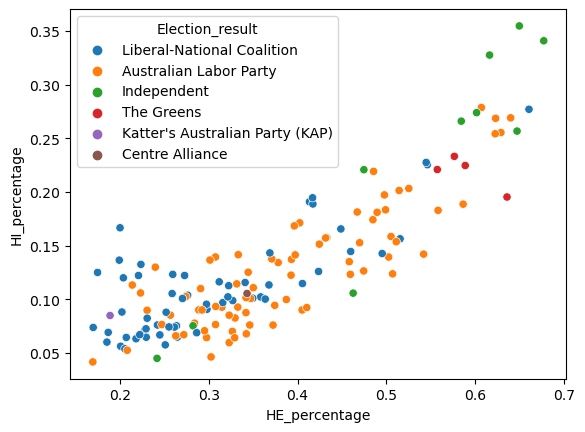

In [19]:
sns.scatterplot(x = "HE_percentage", y = "HI_percentage", hue = "Election_result", data = data)

<Axes: xlabel='Avg_Age', ylabel='HI_percentage'>

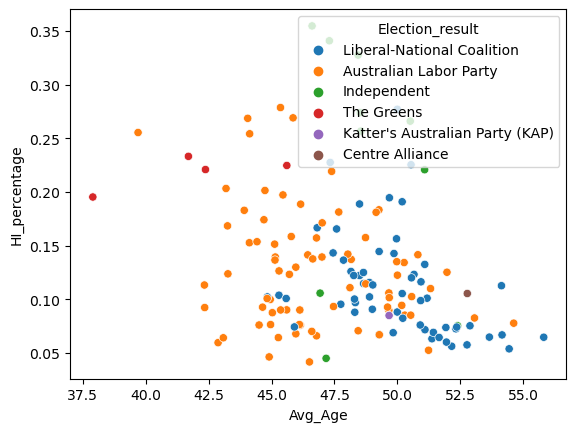

In [20]:
sns.scatterplot(x = "Avg_Age", y = "HI_percentage", hue = "Election_result", data = data)

<Axes: xlabel='Avg_Age', ylabel='HE_percentage'>

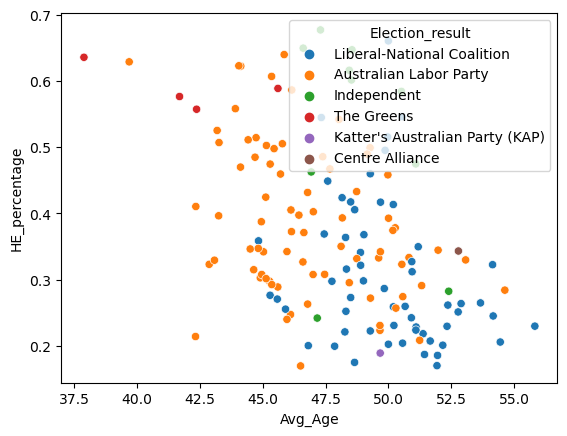

In [21]:
sns.scatterplot(x = "Avg_Age", y = "HE_percentage", hue = "Election_result", data = data)

In [22]:
data[["HE_percentage", "HI_percentage", "Avg_Age"]].corr()

,HE_percentage,HI_percentage,Avg_Age
HE_percentage,1.000000,0.851220,-0.444503
HI_percentage,0.851220,1.000000,-0.310442
Avg_Age,-0.444503,-0.310442,1.000000


Judging by the graphs plotted above, we can see that:
1) The educated and high-income percentages seem to be correlated, which is also confirmed by the correlation coefficient of .85
2) If viewed in terms of a two-party system, i.e. Liberal-National coalition and Labor party, it seems that electoral districts with higher educated and high-income percentages and lower average age tend to vote for Labor, while the Coalition parties seem to be winning in districts that are on average older, less educated and lower income.

## Application of ML algorithms

In this section we will apply ML algorithms to the data to try and build predictive models. First, we should start with preparing the data by Dncoding the winning party label by CED

In [23]:
#Encode the Winning Party label
ord_enc = LabelEncoder()
data.loc[:, "Election_result_enc"] = ord_enc.fit_transform(data['Election_result'].to_numpy())

In [24]:
data

,HE_percentage,HI_percentage,Avg_Age,Election_result,Election_result_enc
CED,,,,,
Banks,0.423576,0.126030,48.156554,Liberal-National Coalition,4
Barton,0.459313,0.123338,45.707484,Australian Labor Party,0
Bennelong,0.586280,0.188710,46.155755,Australian Labor Party,0
Berowra,0.546013,0.225480,50.544414,Liberal-National Coalition,4
Blaxland,0.302552,0.046420,44.904064,Australian Labor Party,0
...,...,...,...,...,...
Lingiari,0.213892,0.113392,42.329036,Australian Labor Party,0
Solomon,0.396256,0.168494,43.248606,Australian Labor Party,0
Bean,0.485470,0.219275,47.387851,Australian Labor Party,0


### Income-Education Linear Regression

Here we will apply a linear regression model to try and predict if a CED would have higher high-income percentage if it has high higher-education percentage.

In [25]:
#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data[['HE_percentage']], data[['HI_percentage']], random_state = 69, test_size=0.15)

In [26]:
#Apply linear regression model and output coefficients
lm = LinearRegression()
lm.fit(X_train, y_train)
print("y = x *", lm.coef_, "+", lm.intercept_)

y = x * [[0.42680474]] + [-0.02641353]


In [27]:
#Compute and output the model's accuracy scores - R2 and MSE
y_pred = lm.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE:", mse)
print("R Squared:", r2)

MSE: 0.001474896655270532
R Squared: 0.6578244334959371


<Axes: xlabel='HE_percentage', ylabel='HI_percentage'>

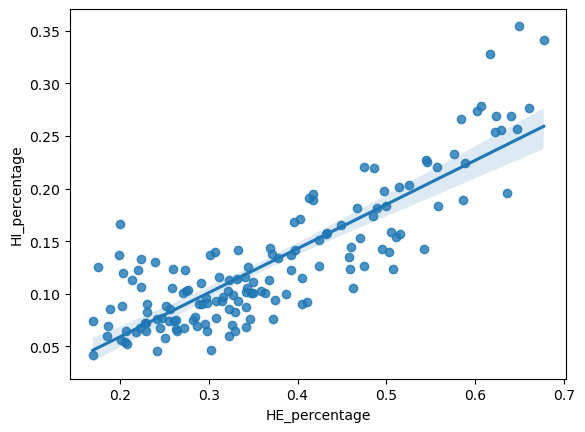

In [28]:
#Plot the data and the regression line
slope = int(lm.coef_)
intercept = int(lm.intercept_)
sns.regplot(x="HE_percentage", y="HI_percentage", data=data)

The model's parameters are calculated and it's line is plotted above. Judging by the accuracy parameters, the Mean Square Error is rather low, meaning that the model's predictions are fairly accurate. The R2 parameter is at 0.65, meaning it describes a moderate percentage of the data's variance.

### KNN Classification

In this section we will apply the KNN algorithm to try and predict the outcome of an election in a CED by it's demographic parameters. To determine the best K hyperparameter for this model, we will conduct some cross-validation using GridSearchCV.

In [29]:
#Determine the optimal K hyperparameter value by Cross-Validation
X = data.drop(['Election_result', 'Election_result_enc'], axis = 1)
y = data['Election_result_enc']

parameter_grid = {'n_neighbors': range(1, 100, 1)}
knn_clf = KNeighborsClassifier()

gs_knn = GridSearchCV(knn_clf, parameter_grid, scoring = 'accuracy', cv = KFold(n_splits = 10, shuffle=True))
gs_knn.fit(X.to_numpy(), y.to_numpy())

print(gs_knn.best_params_['n_neighbors'])
print(gs_knn.best_score_)

39
0.6745833333333333


In [30]:
#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 69, test_size=0.15)

In [31]:
#Apply the KNN model to our data with an optimal K value
clf_knn = KNeighborsClassifier(n_neighbors=9)
clf_knn.fit(X_train, y_train)

#Compute and output the model's accuracy based on testing data
y_pred = clf_knn.predict(X_test)
accsy = accuracy_score(y_test, y_pred)
print('KNN Accuracy is', accsy)

KNN Accuracy is 0.782608695652174


We have trained the KNN model and evaluated the result. The model's tested is accuracy is at 0.78, which is a fairly high accuracy. Judging by this, we can conclude that demographic data of an electoral distirct can be used to predict an outcome of an election in said district with a reasonably high accuracy.

## Additional graphs

In these section we will plot more graphs of our data to evaluate it a little more.

In this section we will use the encoded winning party names to not clutter the plot.

In [32]:
#Display the party name and the corresponding encoded value
data.groupby(["Election_result", "Election_result_enc"]).size()

Election_result                  Election_result_enc
Australian Labor Party           0                      77
Centre Alliance                  1                       1
Independent                      2                      10
Katter's Australian Party (KAP)  3                       1
Liberal-National Coalition       4                      58
The Greens                       5                       4
dtype: int64

|Party name|Encoded label|
|:-----:|:-----:|
|Australian Labor Party|0|
|Centre Alliance|1|
|Independent|2|
|Katter's Australian Party (KAP)|3|
|Liberal-National Coalition|4|
|The Greens|5|

<Axes: xlabel='Election_result_enc', ylabel='HI_percentage'>

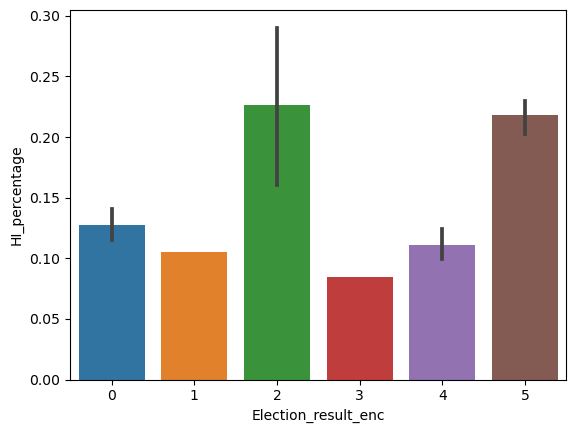

In [33]:
sns.barplot(x = 'Election_result_enc', y = 'HI_percentage', data = data)

<Axes: xlabel='Election_result_enc', ylabel='HE_percentage'>

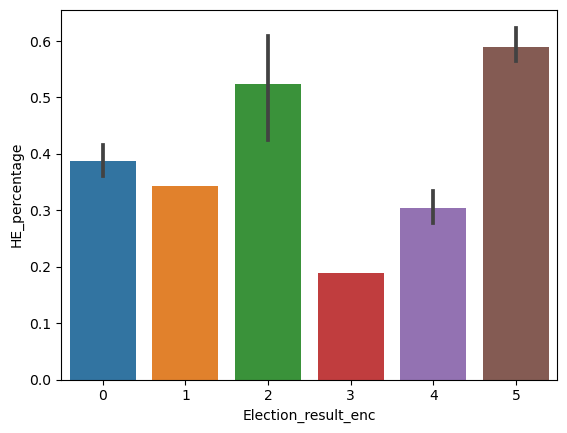

In [34]:
sns.barplot(x = 'Election_result_enc', y = 'HE_percentage', data = data)

This is are plots of the party names against the mean percentage of high income and the mean percentage of higher education people in CEDs where they have won. As we can see, the most high-income and high-education districts tend to vote for The Greens and Independent candidates. Such districts are in the minority, however, since both those groups received very few seats in the Parliament in 2022 election.

The next by popularity for high-income and high-education areas is the Australian Labor party, and this party won a significant amount of seats in Parliament. This relationship we could also observe on the graphs plotted in the Preliminary Analysis section.